In [14]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import tqdm

class CatNotCatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the animal subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load all image file paths and their labels ('cat' or 'not cat')
        for sub_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, sub_dir)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(class_path, img_file)
                        # Label 1 for cat, 0 for not cat
                        label = 1 if sub_dir.lower() == 'cat' else 0
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

dataset = CatNotCatDataset(root_dir='one_vs_rest', transform=transform)


from sklearn.model_selection import KFold
import numpy as np

# Assuming dataset is your CatDogDataset instance
dataset_size = len(dataset)
indices = list(range(dataset_size))

kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CatOrNotCNN(nn.Module):
    def __init__(self):
        super(CatOrNotCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 56 * 56, out_features=512)
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cat or not

    def forward(self, x):
        # Store conv layer outputs in a list
        outputs = []

        x1 = self.pool(F.relu(self.conv1(x)))
        outputs.append(x1)
        x2 = self.pool(F.relu(self.conv2(x1)))
        outputs.append(x2)

        x = torch.flatten(x2, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x, outputs  # Return the final output and the conv layer outputs


In [18]:
def visualize_feature_maps(feature_maps):
    for layer, f_map in enumerate(feature_maps):
        layer += 1  # Start layer indexing at 1
        channels = f_map.shape[1]
        
        for i in range(channels):
            plt.figure(figsize=(4, 4))  # Size for individual images
            plt.imshow(f_map[0, i].detach().cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.show()


In [12]:
def train_model(model, train_loader, val_loader, num_epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm.tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)  # No need for conv_outputs here
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)  # No need for conv_outputs here
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%')

def train_model_for_fold(model, train_indices, val_indices):
    # Subset the dataset for the current fold
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_indices)
    
    # Create data loaders for the current fold
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)
    
    # Place your existing training code here, modified to use the fold's loaders
    # Make sure to reset the model to its initial state before training
    train_model(model, train_loader, val_loader, num_epochs=3)
    return val_loader

# Loop over each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(indices)):
    print(f"Training on fold {fold+1}/3...")
    # Initialize your model for each fold
    model = CatOrNotCNN()
    val_loader = train_model_for_fold(model, train_indices, val_indices)

print('Finished Training')

Training on fold 1/3...


 33%|███▎      | 1/3 [00:35<01:11, 35.90s/it]

Epoch 1, Loss: 1.0972543461964681, Validation Loss: 0.33641420477735146, Accuracy: 91.91919191919192%


 67%|██████▋   | 2/3 [01:10<00:35, 35.43s/it]

Epoch 2, Loss: 0.3914692929157844, Validation Loss: 0.251827991434506, Accuracy: 91.91919191919192%


100%|██████████| 3/3 [01:47<00:00, 35.86s/it]

Epoch 3, Loss: 0.26116474402638584, Validation Loss: 0.31319535417216166, Accuracy: 90.9090909090909%
Training on fold 2/3...



 33%|███▎      | 1/3 [00:35<01:10, 35.29s/it]

Epoch 1, Loss: 0.7568261859795222, Validation Loss: 0.40310854996953693, Accuracy: 87.87878787878788%


 67%|██████▋   | 2/3 [01:11<00:35, 35.59s/it]

Epoch 2, Loss: 0.28063239042575544, Validation Loss: 0.4342660095010485, Accuracy: 87.87878787878788%


100%|██████████| 3/3 [01:45<00:00, 35.17s/it]

Epoch 3, Loss: 0.21313820807979658, Validation Loss: 0.4131442393575396, Accuracy: 87.87878787878788%
Training on fold 3/3...



 33%|███▎      | 1/3 [00:35<01:11, 35.58s/it]

Epoch 1, Loss: 0.8537131043580862, Validation Loss: 0.348752762856228, Accuracy: 89.8989898989899%


 67%|██████▋   | 2/3 [01:11<00:35, 35.73s/it]

Epoch 2, Loss: 0.3143646006400769, Validation Loss: 0.4978011761392866, Accuracy: 89.8989898989899%


100%|██████████| 3/3 [01:45<00:00, 35.12s/it]

Epoch 3, Loss: 0.21963075304833743, Validation Loss: 0.27538227130259785, Accuracy: 89.8989898989899%
Finished Training


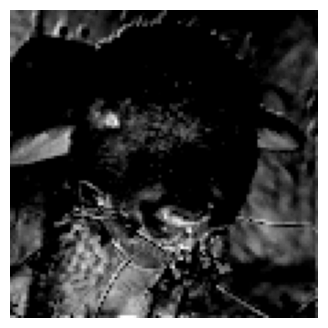

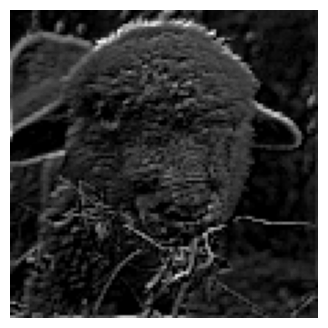

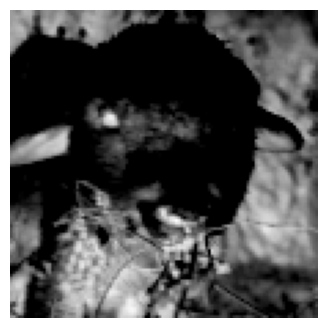

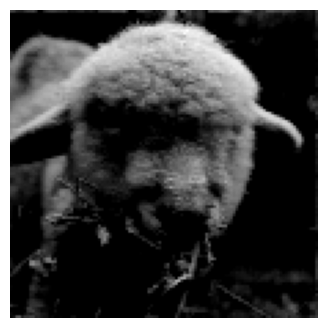

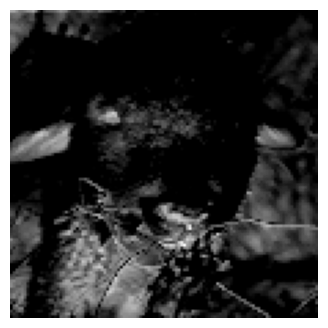

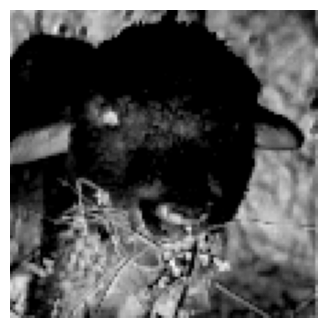

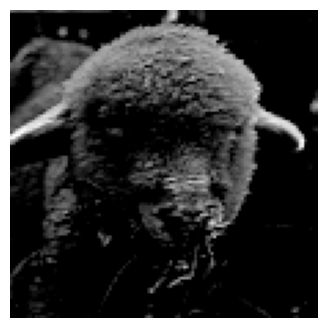

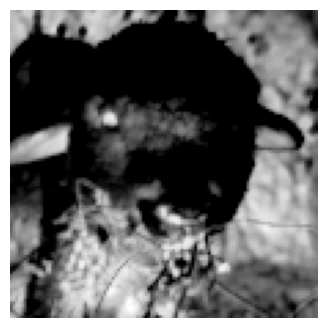

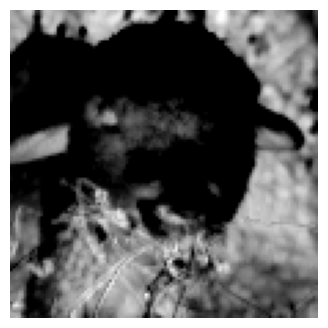

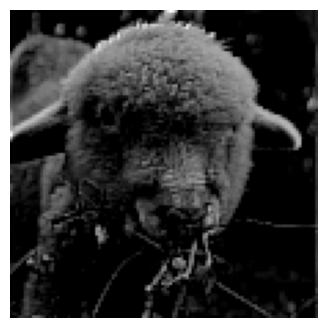

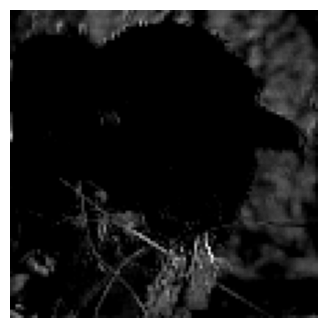

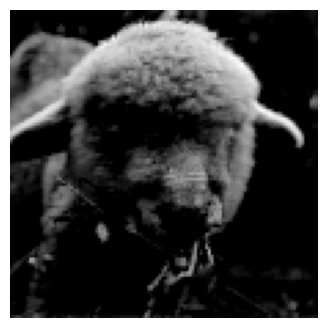

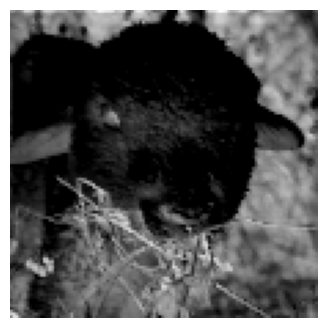

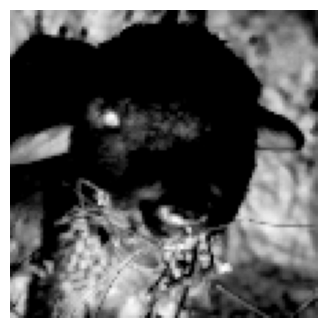

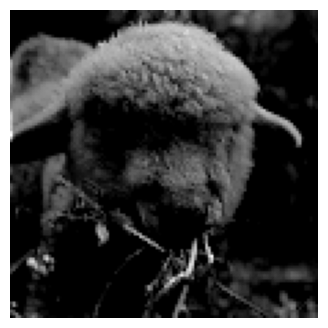

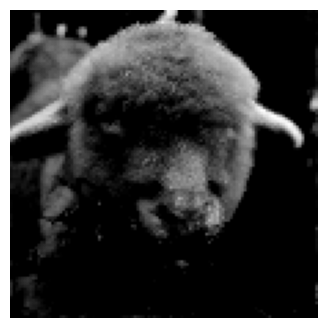

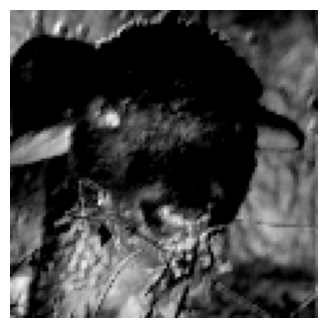

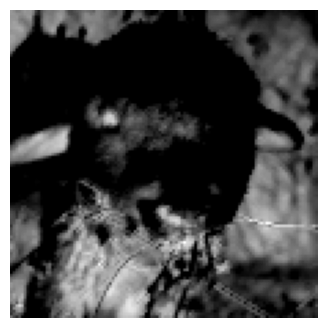

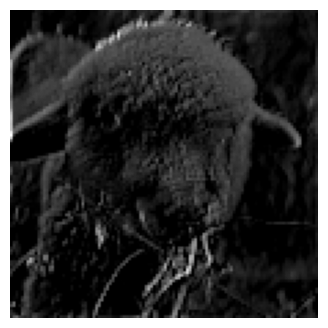

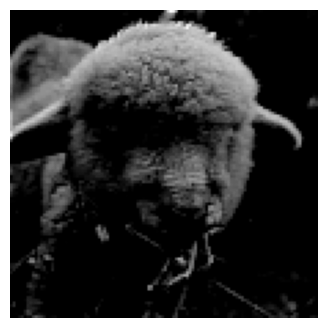

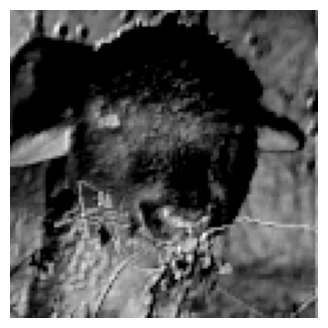

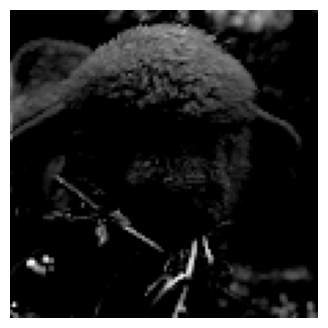

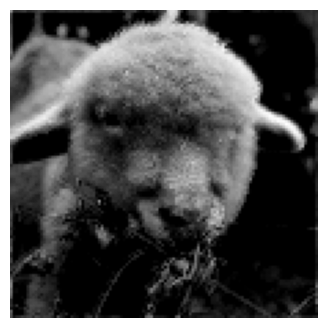

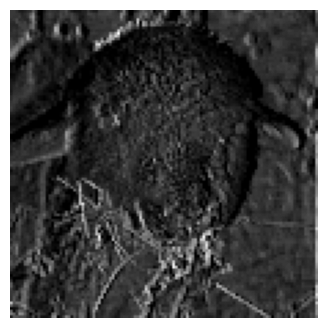

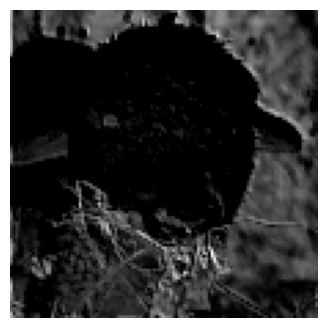

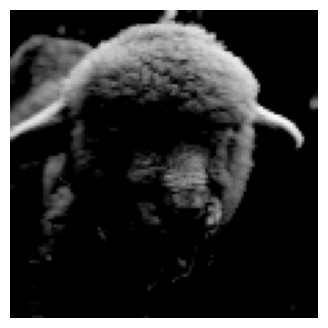

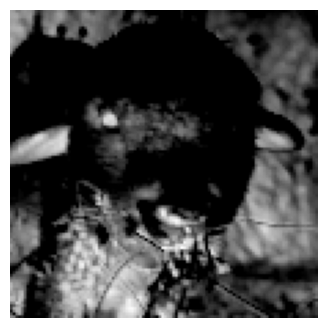

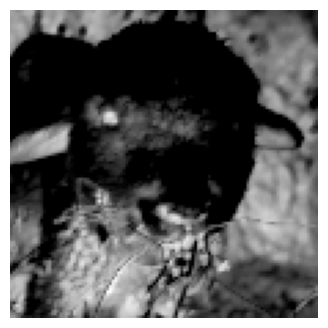

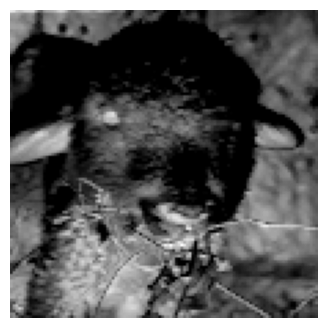

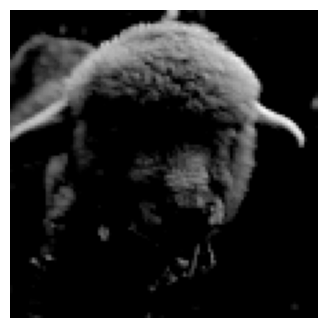

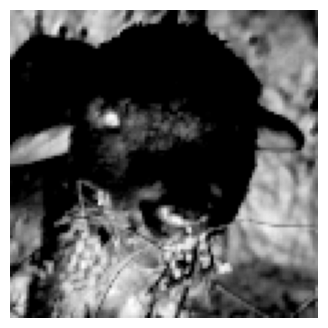

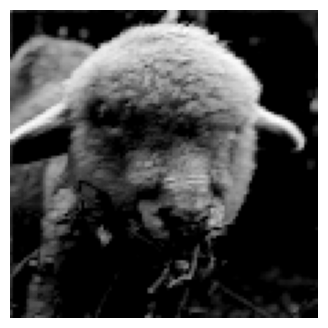

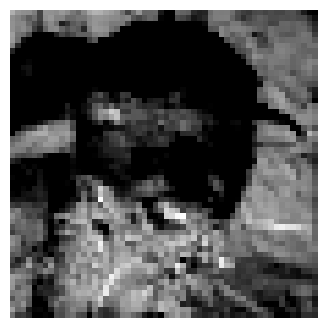

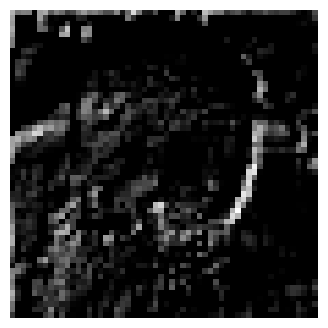

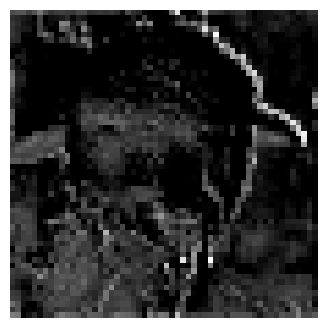

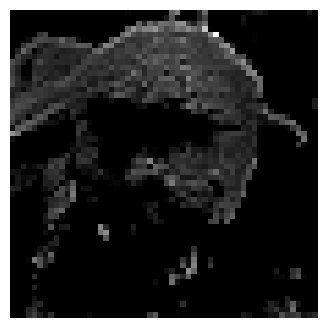

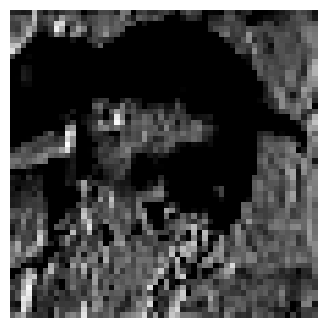

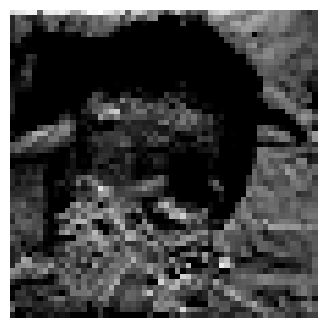

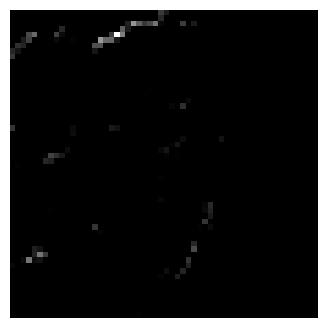

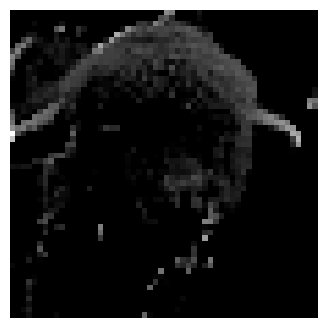

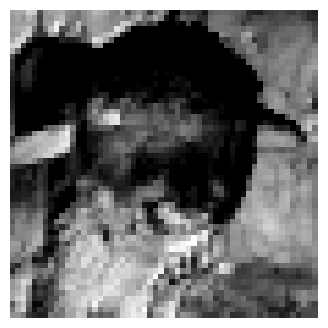

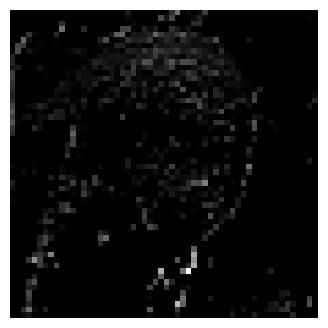

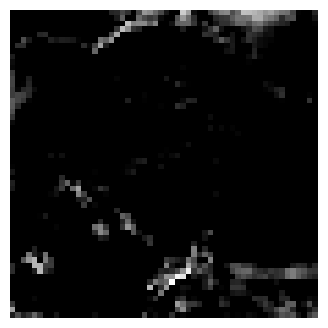

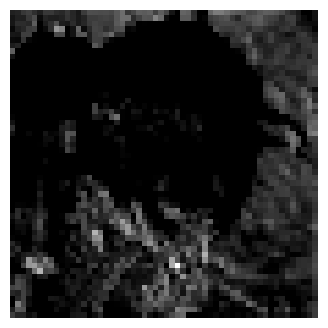

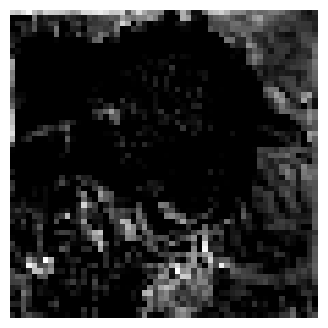

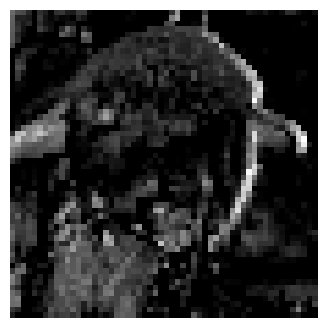

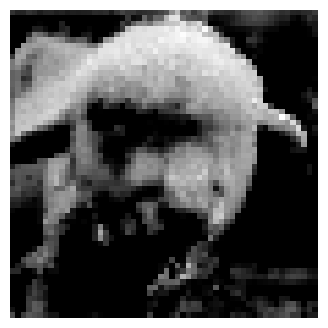

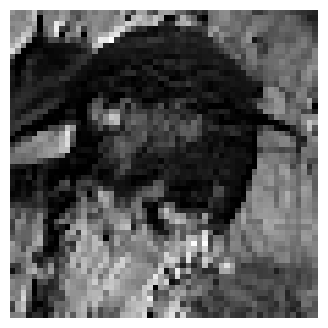

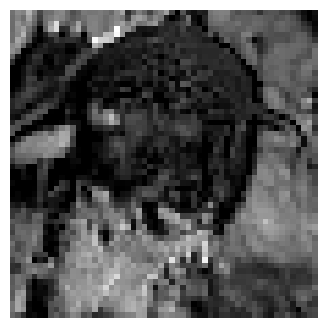

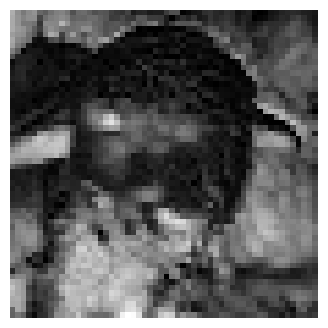

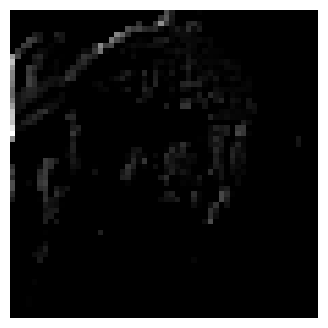

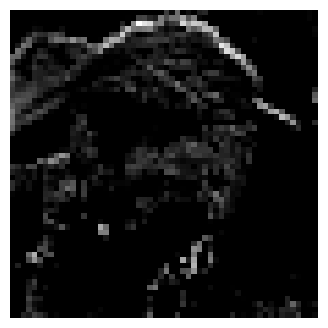

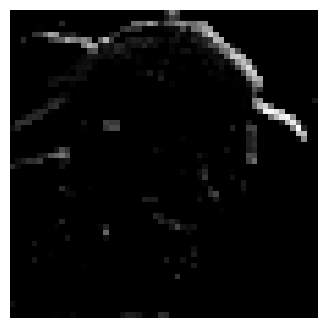

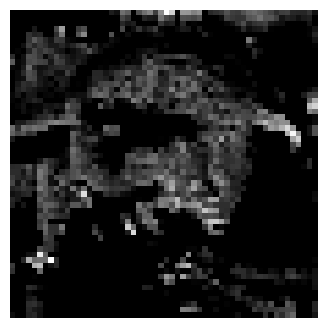

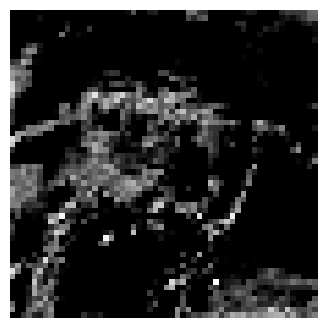

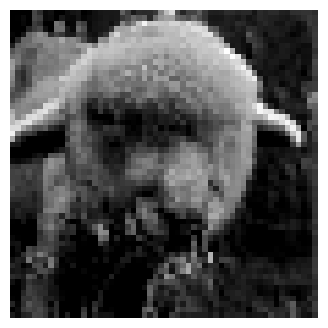

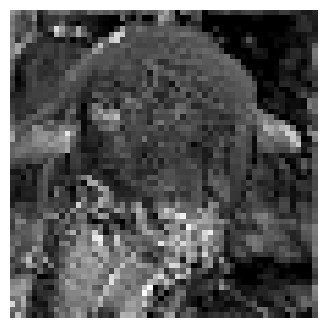

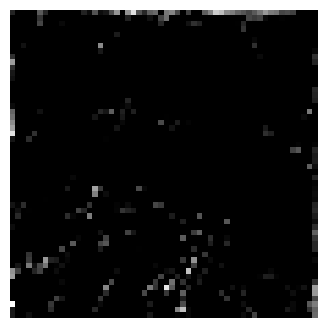

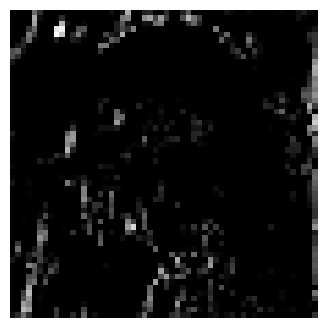

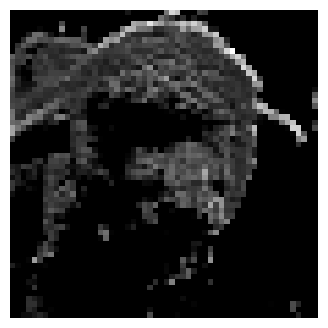

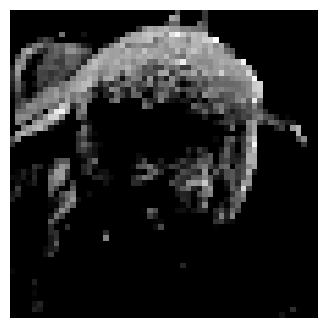

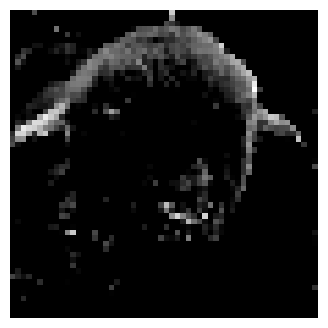

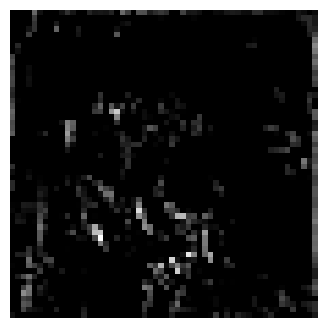

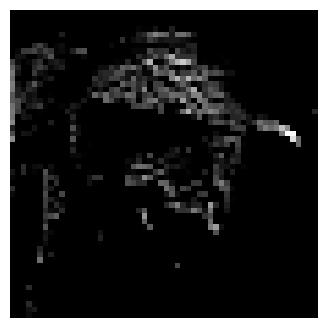

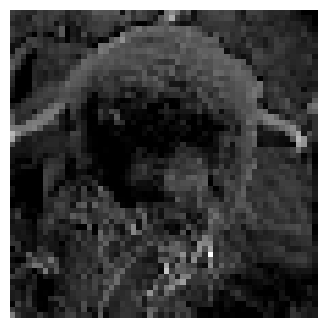

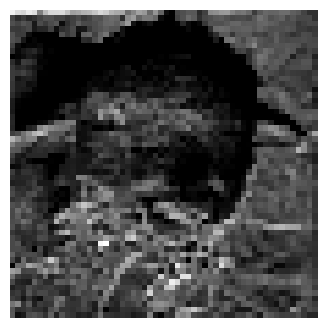

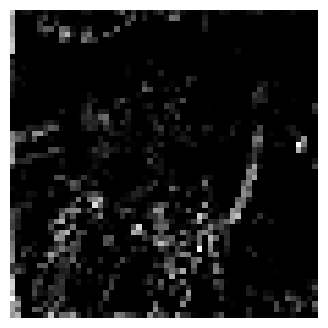

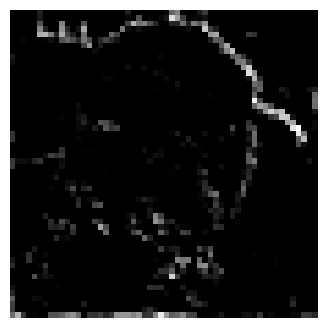

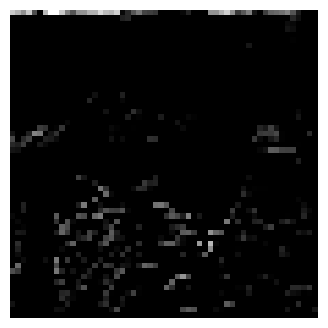

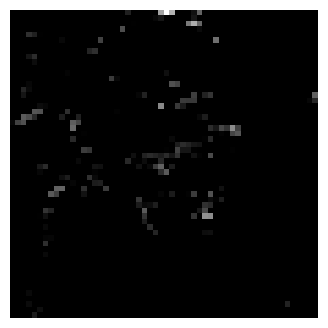

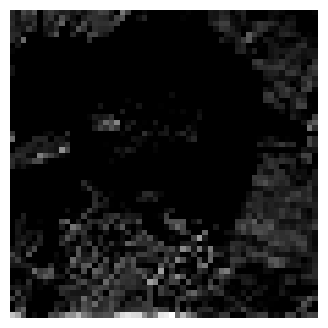

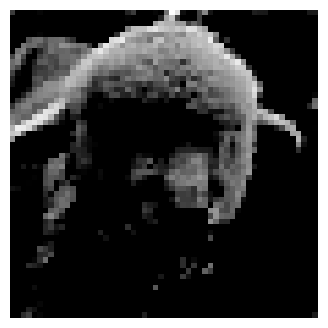

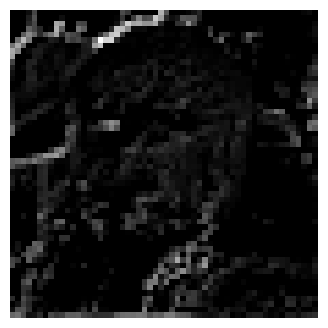

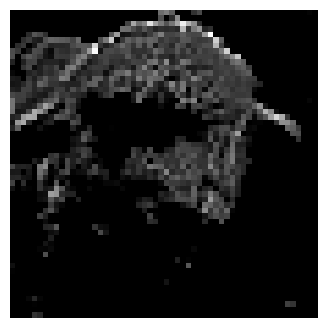

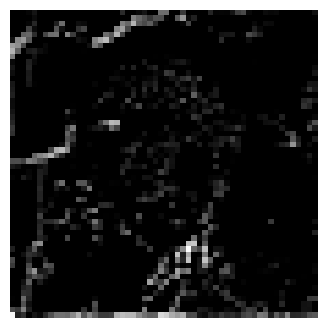

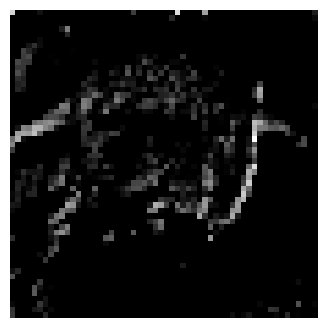

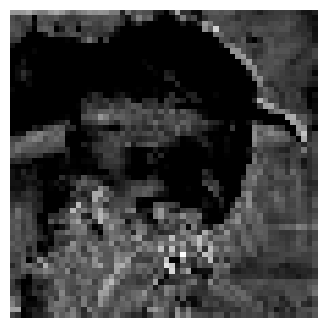

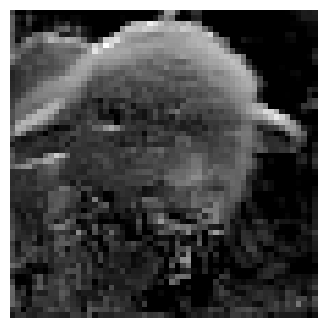

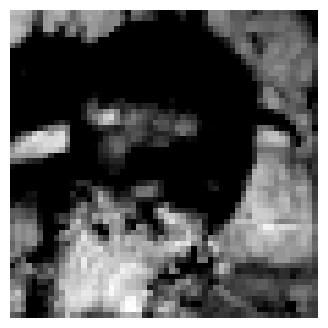

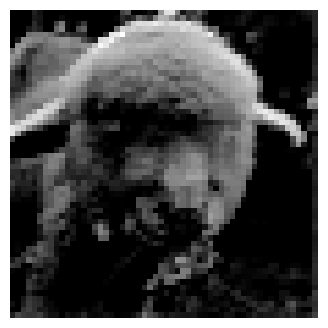

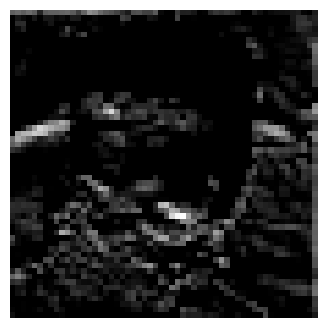

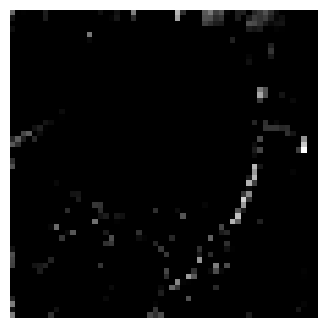

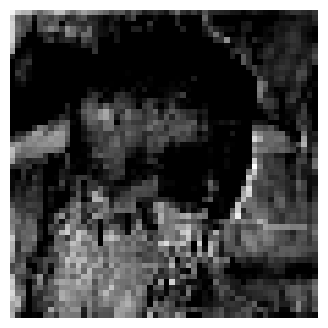

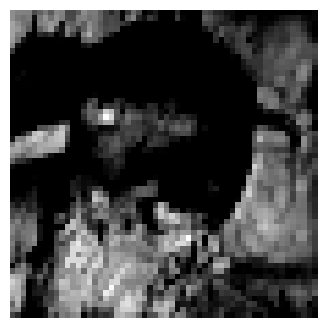

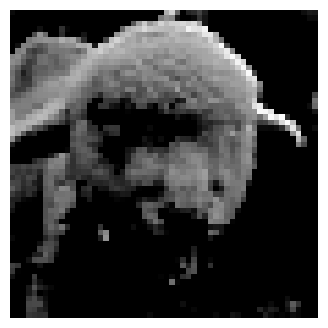

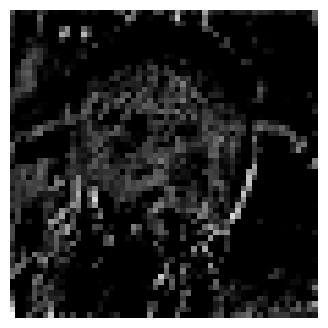

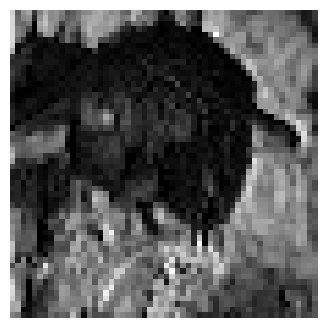

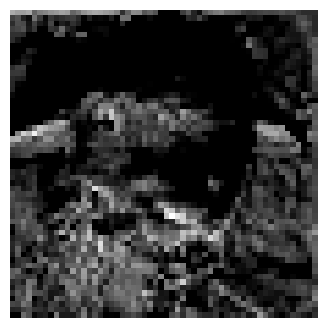

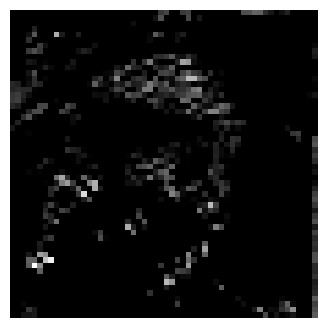

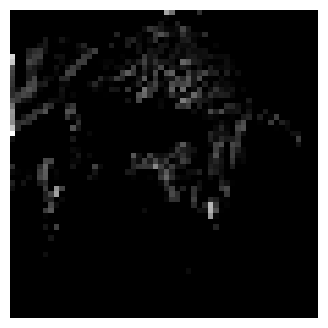

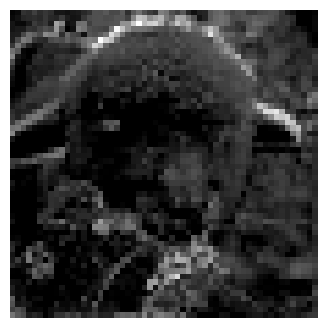

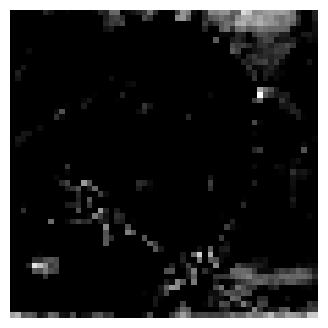

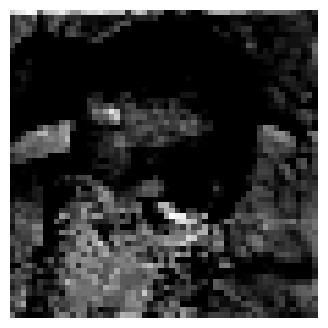

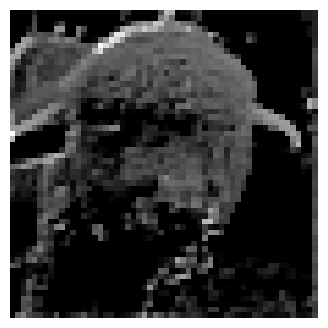

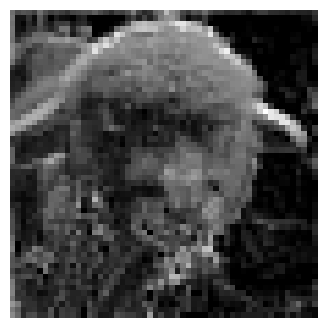

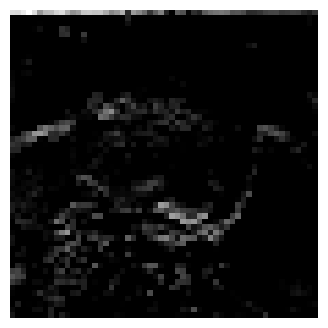

In [19]:
# Assume 'model' is your trained CatOrNotCNN model
# and 'val_loader' is your DataLoader for the validation set

# Turn model to evaluation mode
model.eval()

# Get a single batch of images
images, labels = next(iter(val_loader))

# Move images to the same device as model
images = images.to(next(model.parameters()).device)

# Forward pass to get outputs and feature maps
with torch.no_grad():
    _, feature_maps = model(images)

# Visualize feature maps for the first image in the batch
visualize_feature_maps(feature_maps)
